# Exploratory Data Analysis - IAM Handwritten Forms

In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random

In [16]:
iam_root = 'data/'

writer_dirs = sorted([d for d in os.listdir(iam_root) 
                      if os.path.isdir(os.path.join(iam_root, d)) 
                      and d.isdigit()])

print(f"Total number of writers: {len(writer_dirs)}")
print(f"Writer ID range: {writer_dirs[0]} to {writer_dirs[-1]}")

Total number of writers: 657
Writer ID range: 000 to 671


In [17]:
forms_per_writer = {}
total_forms = 0

for writer_id in writer_dirs:
    writer_path = os.path.join(iam_root, writer_id)
    forms = [f for f in os.listdir(writer_path) if f.endswith('.png')]
    forms_per_writer[int(writer_id)] = len(forms)
    total_forms += len(forms)

print(f"Total form images: {total_forms}")

Total form images: 1539


In [18]:
forms_count = np.array(list(forms_per_writer.values()))

stats = {
    "Mean": float(forms_count.mean()),
    "Median": float(np.median(forms_count)),
    "Mode": int(pd.Series(forms_count).mode().iloc[0]),
    "Min": int(forms_count.min()),
    "Max": int(forms_count.max()),
    "Std Dev": float(forms_count.std()),
    "Variance": float(forms_count.var())
}

df_stats = pd.Series(stats).rename("value").to_frame()
# format values: integers without decimals, floats with 1 decimal
def fmt(v):
    if isinstance(v, (int, np.integer)):
        return f"{v:,}"
    return f"{v:,.1f}"

df_stats["formatted"] = df_stats["value"].apply(fmt)
df_stats = df_stats[["formatted"]].rename(columns={"formatted": "Value"})

print("Forms per writer summary:")
display(df_stats)

Forms per writer summary:


,Value
Mean,2.3
Median,1.0
Mode,1.0
Min,1.0
Max,59.0
Std Dev,3.0
Variance,9.2


In [19]:
print("Sample writer directories:")
for writer_id in random.sample(writer_dirs, 10):
    num_forms = forms_per_writer[int(writer_id)]
    print(f"    Writer {writer_id}: {num_forms} forms")

Sample writer directories:
    Writer 384: 10 forms
    Writer 480: 2 forms
    Writer 612: 1 forms
    Writer 036: 1 forms
    Writer 060: 4 forms
    Writer 156: 1 forms
    Writer 136: 1 forms
    Writer 644: 1 forms
    Writer 022: 1 forms
    Writer 164: 2 forms


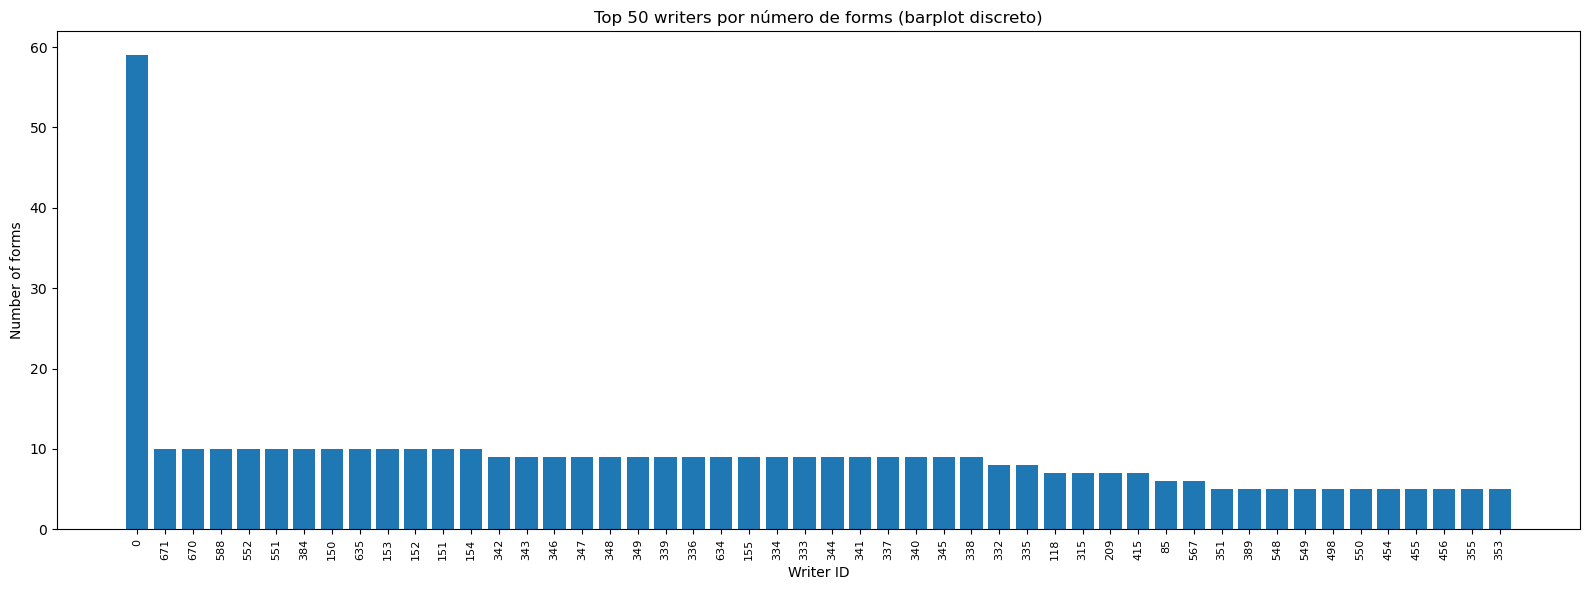

In [20]:
df_writers = pd.DataFrame(list(forms_per_writer.items()), columns=['writer_id', 'count'])
df_writers['writer_id'] = df_writers['writer_id'].astype(str)
top50 = df_writers.sort_values('count', ascending=False).head(50).reset_index(drop=True)

plt.figure(figsize=(16, 6))
plt.bar(top50['writer_id'], top50['count'], color='tab:blue')
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('Writer ID')
plt.ylabel('Number of forms')
plt.title('Top 50 writers por número de forms (barplot discreto)')
plt.tight_layout()
plt.show()

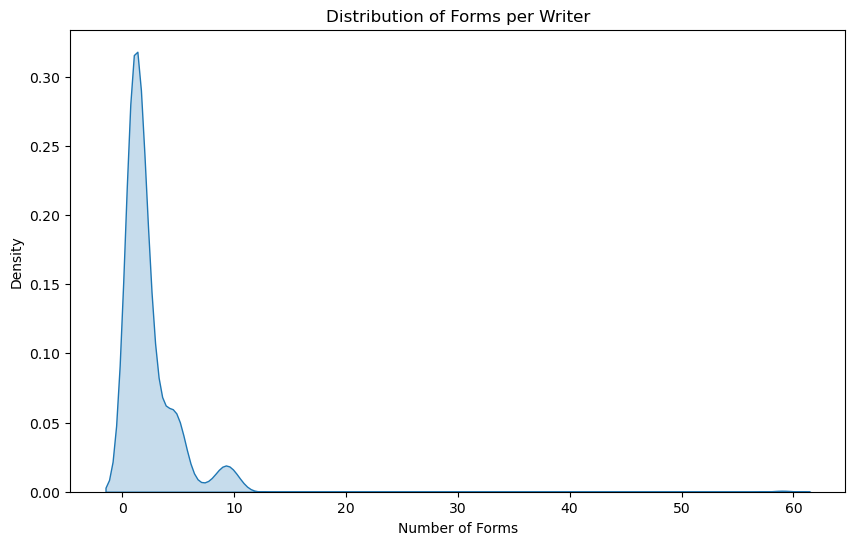

In [21]:
plt.figure(figsize=(10, 6))
sns.kdeplot(forms_count, fill=True)
plt.title('Distribution of Forms per Writer')
plt.xlabel('Number of Forms')
plt.ylabel('Density')
plt.show()

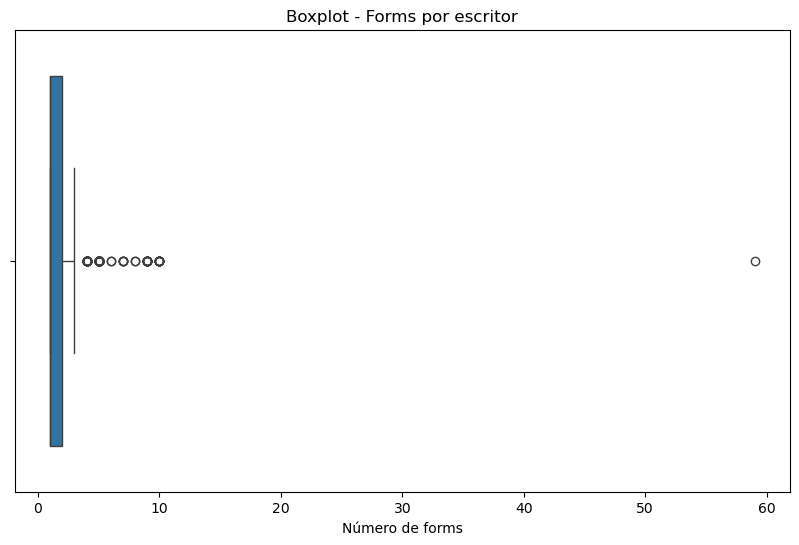

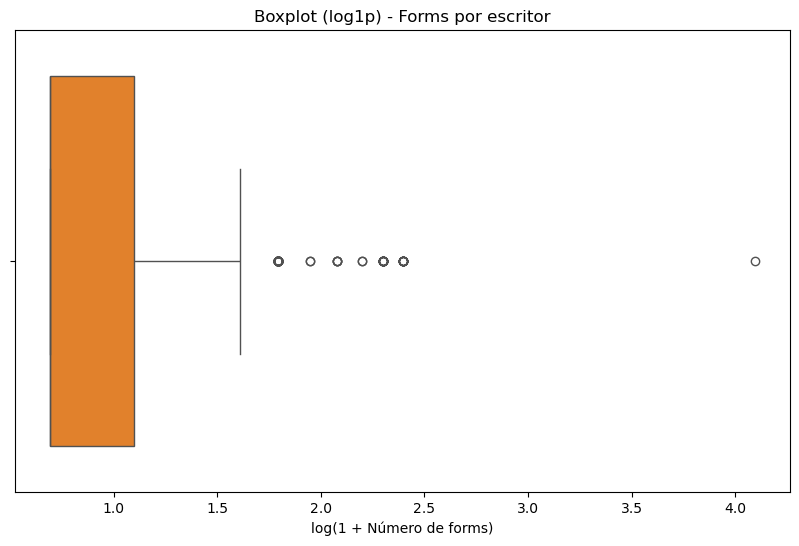

In [22]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=forms_count, color='tab:blue')
plt.title('Boxplot - Forms por escritor')
plt.xlabel('Número de forms')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=np.log1p(forms_count), color='tab:orange')
plt.title('Boxplot (log1p) - Forms por escritor')
plt.xlabel('log(1 + Número de forms)')
plt.show()